## Setup

In [2]:
# boilerplate code
import os
from io import BytesIO
import numpy as np
import time
import PIL.Image
from IPython.display import clear_output, Image, display
from __future__ import print_function, division

import tensorflow as tf

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

with tf.gfile.FastGFile(model_fn, 'rb') as f:
    # create an empty GraphDef object; this is the object we'll populate w/ data from the file
    graph_def = tf.GraphDef()
    # read binary data (different protocol for textual GraphDef objects); graph_def now contains
    # operations to be imported into the default graph
    graph_def.ParseFromString(f.read())
    
# define the input tensor
t_input = tf.placeholder(np.float32, name='input') 
# ?
imagenet_mean = 117.0
# subtract mean from all input data
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
# import graph_def into the Python Graph; second argument is dictionary mapping input names in
# graph_def to Tensor objects
tf.import_graph_def(graph_def, {'input':t_preprocessed})

## Helper Functions

In [3]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    # create an empty (?) file object
    f = BytesIO()
    # save array to file object
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("%s:0"%layer)

# Helper functions that use TF to resize an image
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

## Deep Dream

In [4]:
def render_deepdream(t_obj, img, mask, disp=True,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    
    # make sure t_obj and mask dims match
    assert (mask.shape[:2] == img.shape[:2]), "Mask and image do not share same dimensions"
    
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image and mask into a number of octaves
    octaves = []
    octaves_mask = []
    
    if disp:
        print("Splitting image into octaves ...")
        
    for i in range(octave_n-1):
        
        # image
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
        
        # mask
        hw_mask = mask.shape[:2]
        lo_mask = resize(mask, np.int32(np.float32(hw_mask)/octave_scale))
        hi_mask = mask-resize(lo_mask, hw_mask)
        mask = lo_mask
        octaves_mask.append(hi_mask)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
            hi_mask = octaves_mask[-octave]
            mask = resize(mask, hi_mask.shape[:2])+hi_mask
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += np.multiply(mask/255, g) * (step / (np.abs(g).mean()+1e-7))
            if disp:
                print('.',end = ' ')

        if disp:
            clear_output()
            showarray(img/255.0)
        
    return img

In [66]:
def render_deepdream_2masks(t_obj1, t_obj2, img, mask1, mask2, disp=True,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    
    # make sure t_obj and mask dims match
    assert (mask1.shape[:2] == img.shape[:2]), "Mask and image do not share same dimensions"
    assert (mask2.shape[:2] == img.shape[:2]), "Mask and image do not share same dimensions"
    
    t_score1 = tf.reduce_mean(t_obj1) # defining the optimization objectives
    t_score2 = tf.reduce_mean(t_obj2) # defining the optimization objectives
    t_grad1 = tf.gradients(t_score1, t_input)[0] # behold the power of automatic differentiation!
    t_grad2 = tf.gradients(t_score2, t_input)[0] # behold the power of automatic differentiation!

    # split the image and mask into a number of octaves
    octaves = []
    octaves_mask1 = []
    octaves_mask2 = []
    
    if disp:
        print("Splitting image into octaves ...")
        
    for i in range(octave_n-1):
        
        # image
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
        
        # mask1
        hw_mask1 = mask1.shape[:2]
        lo_mask1 = resize(mask1, np.int32(np.float32(hw_mask1)/octave_scale))
        hi_mask1 = mask1-resize(lo_mask1, hw_mask1)
        mask1 = lo_mask1
        octaves_mask1.append(hi_mask1)

        # mask2
        hw_mask2 = mask2.shape[:2]
        lo_mask2 = resize(mask2, np.int32(np.float32(hw_mask2)/octave_scale))
        hi_mask2 = mask2-resize(lo_mask2, hw_mask2)
        mask2 = lo_mask2
        octaves_mask2.append(hi_mask2)

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
            hi_mask1 = octaves_mask1[-octave]
            mask1 = resize(mask1, hi_mask1.shape[:2])+hi_mask1
            hi_mask2 = octaves_mask2[-octave]
            mask2 = resize(mask2, hi_mask2.shape[:2])+hi_mask2
        for i in range(iter_n):
            g1 = calc_grad_tiled(img, t_grad1)
            g2 = calc_grad_tiled(img, t_grad2)
            img += np.multiply(mask1/255, g1) * (step / (np.abs(g1).mean()+1e-7)) \
                    + np.multiply(mask2/255, g2) * (step / (np.abs(g2).mean()+1e-7))
            if disp:
                print('.',end = ' ')

        if disp:
            clear_output()
            showarray(img/255.0)
        
    return img

## Full Example

In [21]:
# import image
img = PIL.Image.open('/home/mattw/Dropbox/deep-dream/trees/osa_island.jpg')
img = np.float32(img)
# showarray(img/255.0)

# for exporting
dir_path = '/home/mattw/results/deep-dream/trees/osa_island'

# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# loop over selected layers
# layer_nums = [1]
layer_nums = range(24, len(layers), 2)
layer_counter = 0
start = time.time()
for layer_num in layer_nums:

    # get string for saving
    layer_folder = 'layer_%03i' % layer_num
    folder_path = '/'.join([dir_path, layer_folder])
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    
    # use string to get layer output by name
    layer = layers[layer_num] 
    
    # loop over selected features
    feature_nums = [3, 6, 9]
    feature_nums = range(0, features[layer_num])
    
    # print updates
    layer_counter += 1
    print("Layer %i OF %i" % (layer_counter, len(layer_nums)))
    
    feature_counter = 0
    for feature_num in feature_nums:

        # print updates
        feature_counter += 1
        print("\rFeature %03i of %03i" % (feature_counter, len(feature_nums)), end="")
        
        # run deep dream; more iterations intensifies features, more octaves increases their size
        img = render_deepdream(T(layer)[:,:,:,feature_num], img0, iter_n=20, octave_n=4, disp=False)
        img = np.uint8(np.clip(img, 0, 255))
        
        # save output
        feature_name = "layer_%02i_feature_%03i.jpg" % (layer_num, feature_num)
        file_path = '/'.join([dir_path, layer_folder, feature_name])
        PIL.Image.fromarray(img).save(file_path, 'jpeg')
        
    print("\n")
    
end = time.time()
print("Total Elapsed Time: %i hours" % ((end-start)/3600))

Layer 1 OF 18
Feature 001 of 024

TypeError: render_deepdream() takes at least 3 arguments (5 given)

## Single Mask Example

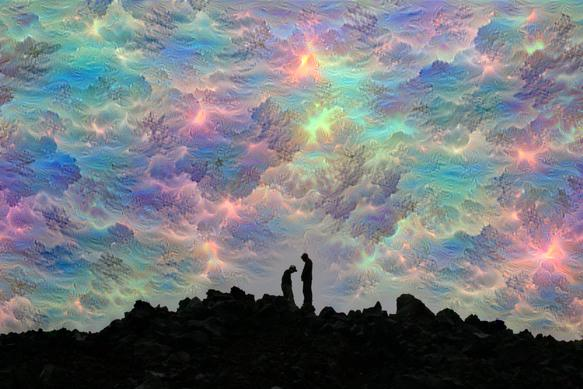

In [93]:
# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# import image
# img = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_gimp_tunnel.JPG')
img = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds.JPG')
img = np.float32(img)

mask = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_CLOUD_mask2.JPG')
mask2 = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_PEOPLE_mask2.JPG')
# mask = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_RIDGE_mask.JPG')

# for ridge
# mask = np.float32(mask)

# for sky
mask = np.float32(mask)/255.0
mask2 = np.float32(mask2)/255.0
mask = np.multiply(mask, mask2)*255.0
     
layer = layers[28]
feature_num = 56

# run deep dream; more iterations intensifies features, more octaves increases their size
# 22/101 - iter_n=100, octave_n=4
img = render_deepdream(T(layer)[:,:,:,feature_num], img, mask, iter_n=40, octave_n=8)

## Double Mask Example

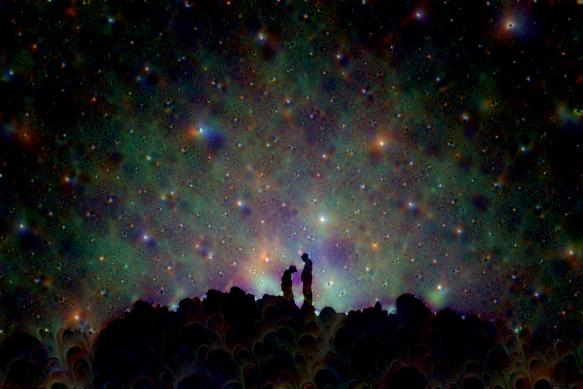

In [98]:
# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# import image
# img = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds.JPG')
img = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_gimp_tunnel.JPG')
img = np.float32(img)

# import masks
mask_a = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_RIDGE_mask.JPG')
mask_b = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_CLOUD_mask.JPG')
mask_c = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_PEOPLE_mask2.JPG')

# for ridge
layer1 = layers[4]
feature_num1 = 19
mask1 = np.float32(mask_a)

# for sky
layer2 = layers[14]
feature_num2 = 55
mask_b = np.float32(mask_b)/255.0
mask_c = np.float32(mask_c)/255.0
mask2 = np.multiply(mask_b, mask_b)*255.0

# run deep dream; more iterations intensifies features, more octaves increases their size
# 22/101 - iter_n=100, octave_n=4
img = render_deepdream_2masks(0.1*T(layer1)[:,:,:,feature_num1], T(layer2)[:,:,:,feature_num2],
                              img, 
                              mask1, mask2,
                              iter_n=10, octave_n=10)

In [80]:
img = np.uint8(np.clip(img, 0, 255))
PIL.Image.fromarray(img).save('/home/mattw/results/deep-dream/clouds/mountain_clouds/final/test_2.jpg', 'jpeg')

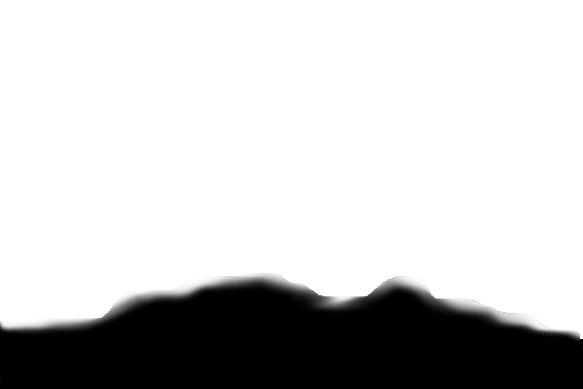

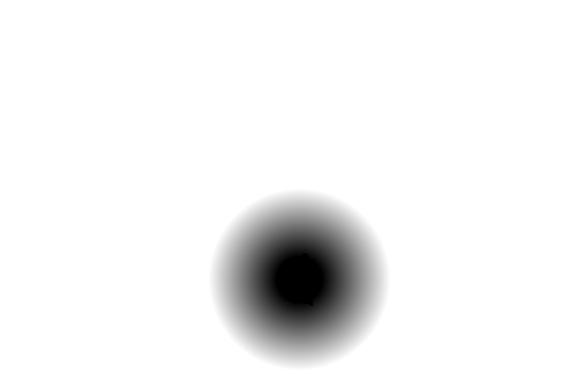

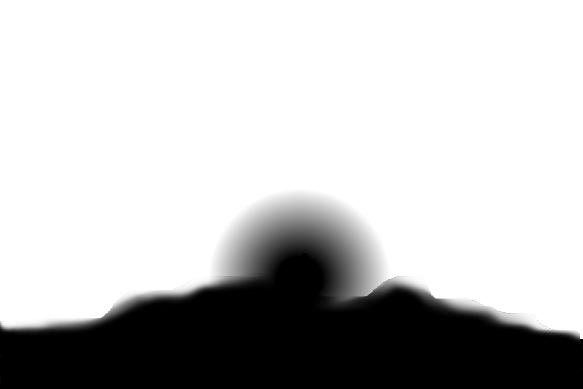

In [32]:
mask = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_CLOUD_mask2.JPG')
mask2 = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds/mountain_clouds_PEOPLE_mask2.JPG')
mask = np.float32(mask)/255.0
mask2 = np.float32(mask2)/255.0
mask3 = np.multiply(mask,mask2)*255.0
showarray(mask)
showarray(mask2)
showarray(mask3/255.0)

In [22]:
mask2[388,582,2]

255.0

In [18]:
mask.shape

(389, 583, 3)

## Notes
### mountain_clouds
- test_1: l28 f56; iter_n=40, octave_n=8
- test_2: ridge l4 f19, sky l14 f55; iter_n=5, octave_n=8

## Other Notes
### Spotty
- 08/022

### Puzzle Pieces
- 08/024
- 10/090
- 16/079
- 22/081

### Spindly/Spider Webs
- 08/006
- 10/000 (structural)
- 10/044
- 14/028
- 14/043
- 16/028
- 20/030
- 20/036
- 20/037
- 20/041
- 22/065
- 22/105
- 28/043
- 28/050
- 28/108

### Abstract Patterns
- many in layer 4
- 10/100
- 14/038
- 16/041
- 16/089
- 20/032
- 20/052
- 20/059
- 20/063
- 22/011
- 22/037
- 22/062
- 22/078
- 22/110
- 24/014
- 26/050
- 26/063
- 32/042
- 34/055
- 34/126
- 44/092

### Waves
- 16/011
- 16/013
- 16/061
- 16/065
- 16/074
- 16/080
- 16/081
- 24/016

### Trees/Grass
- 16/084
- 20/036
- 20/015
- 20/017
- 20/036
- 22/036
- 22/085
- 26/039
- 28/101
- 34/056

### Clouds
- 20/003

### Landscapes
- 20/031
- 22/020
- 26/017
- 28/039

### Cells/Bubbles
- 10/121
- 14/027
- 16/076
- 22/017
- 22/109
- 28/027
- 28/108
- 32/032
- 38/025
- 38/056
- 40/081
- 40/088
- 46/050
- 46/095
- 58/111

### Cylindrical Things
- 26/032
- 28/034
- 28/068
- 34/084
- 34/128
- 38/005
- 38/030
- 42/014
- 44/123
- 46/010
- 46/090
- 46/122

### Psy Waves
- 10/023
- 10/054
- 10/073
- 16/017
- 16/032
- 16/047
- 16/082
- 16/091
- 20/001
- 20/009 (fractally)
- 22/006 (folds)
- 22/042
- 26/006

### Glowing Cosmos
- 10/109
- 14/055
- 20/020
- 20/037
- 22/065
- 26/022
- 26/038
- 26/058
- 28/005
- 32/053
- 34/008
- 34/016
- 34/063
- 38/012
- 40/048
- 44/023
- 50/101 (underwater)
- 50/109 (underwater)
- 58/011
- 58/062

### Arches/Cathedrals/Pagodas
- 20/048
- 22/035
- 32/029
- 32/061
- 34/002
- 34/043
- 34/065
- 34/066
- 34/114
- 34/137
- 38/016

### Animal Patterning
- 28/073 (snake)
- 32/017 (feathers)
- 32/018 (feathers)
- 32/050
- 32/060 (coral)
- 34/016 (fish)
- 34/086 (snake)
- 34/088 (snake)
- 34/089 (scaley)
- 34/113 (feathers)
- 36/011 (feathers)
- 38/032
- 38/057
- 40/124
- 42/012
- 46/045
- 50/101
- 50/109
- 52/028
- 52/060
- 52/076 (coral)
- 52/188
- 58/012
- 58/018
- 58/043 (snake)
- 58/107 (snake)

### Pressed Liquid/Watercolors
- 22/025
- 22/066
- 26/048
- 32/026
- 32/062
- 34/041
- 34/090

### Other
- 38/013 (wolf?)
- 44/100 (vehicles)

### Possibly Interesting Objects
- waterfall
- fire/flame
- cracked glass
- rice paddies
- cliff face
- beaded water drops